# MNIST

Training of a small MLP on MNIST with MSE loss
- MLP = Multi-Layer Perceptron
- MSE = Mean Squared Errors

[Original resource here](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [5]:
# Training settings
batch_size=64 #m
epochs=5
lr=0.01
momentum=0.0
seed=1101

din=784
dout=10
dh=50

nbatches=30 # n.batches to evaluate statistics

In [10]:
class Net(nn.Module):
    """ 
    Simple neural network fee-forward model with one hidden layer:
    The inputs are linearly combined and then passed through a sigmoid activation function.
    """
    def __init__(self,din=784, dh=30, dout=10):
        super(Net, self).__init__()
        
        self.lin1 = nn.Linear(din, dh)
        self.lin2 = nn.Linear(dh, dout)
    
    def forward(self, x):    
        x = torch.sigmoid(self.lin1(x)) 
        return self.lin2(x)

### MSE loss

Lines which are specific to MSE loss are marked with *

**NOTE** Torch tensors have method `to()` (see [doc](https://pytorch.org/docs/stable/tensors.html)), which allow to define a particular device in which to store them

We here define the training function, it uses MSE for computing the loss 

In [16]:
criterion = nn.MSELoss() # *

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    

    for batch_idx, (data, target) in enumerate(train_loader):
        
        # push data (i.e. input values) and targets (i.e. labels) to
        # the device defined to store and compute 
        # ( basically in here we are copying data and target to new objects stored in the required device )
        data, target = data.to(device), target.to(device)
        
        
        data = data.view(-1,784) # *
        target = target.view(-1,1) # *
        onehot = torch.FloatTensor(data.shape[0], 10).zero_().to(device) # *
        # From documentation of torch tensors:
        # scatter_(dim, index, src) → Tensor
        # Writes all values from the tensor src into self at the indices specified in the index tensor. 
        # For each value in src, its output index is specified by its index in src for dimension != dim 
        # and by the corresponding value in index for dimension = di
        onehot.scatter_(1, target, 1) # *
        target = onehot # *
    
        # this line is needed to not sum-up the new gradients with the old ones
        optimizer.zero_grad()
        
        # this returns the predicted value after last training step
        output = model(data)
        
        # compute the loss function with criterion defined above
        loss = criterion(output, target)
        
        # backpropagate the new gradients
        loss.backward()
        
        # update the value of the parameters with the newly computed gradients
        optimizer.step()

Did not get what this is doing:

In [18]:
def stats(model, device, loader, nsamples=batch_size*nbatches):
    """
    Returns value of the loss function and of the accuracy of the model
    for current epoch (also, prints on screen these values)
    """
    
    model.eval() 
    
    loss = 0
    correct = 0
    count = 0
    
    origin = 'train' if loader.dataset.train else 'test'
    
    with torch.no_grad():
        
        for data, target in loader:
            
            count += data.shape[0]
                
            if count > nsamples:
                break
                
            data, target = data.to(device), target.to(device)     
            
            
            data = data.view(-1,784) # *
            target = target.view(-1,1) # *
            onehot = torch.FloatTensor(data.shape[0], 10).zero_().to(device) # *
            onehot.scatter_(1, target, 1) # *
            
    
            output = model(data)
            
            loss += criterion(output, onehot).item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= count  
    acc = 100. * correct / count
    

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(origin,
        loss, correct, count,
        acc ) )
    
    
    return loss,acc

Defining some hiperparameters

In [13]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

And here we define the loaders for train and test sets:

In [14]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

We define the model and save it on the required device

In [15]:
model = Net(din,dh,dout).to(device)

We define the **optimizer** i.e. the algorithm that will be used to **back-propagate** the newly computed gradients, in this case **stocasthic gradient descent** (SGD).

In [10]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

We train the model for `epochs` epochs

In [11]:
train_stats = []
test_stats = []

for epoch in range(1, epochs + 1):
    
    train(model, device, train_loader, optimizer, epoch)
    
    train_stats.append(stats(model, device, train_loader))
    test_stats.append(stats(model, device, test_loader))
    
train_stats = np.array(train_stats)
test_stats = np.array(test_stats)


train set: Average loss: 0.0009, Accuracy: 1423/1984 (72%)


test set: Average loss: 0.0009, Accuracy: 1433/1984 (72%)


train set: Average loss: 0.0008, Accuracy: 1540/1984 (78%)


test set: Average loss: 0.0008, Accuracy: 1540/1984 (78%)


train set: Average loss: 0.0007, Accuracy: 1561/1984 (79%)


test set: Average loss: 0.0007, Accuracy: 1572/1984 (79%)


train set: Average loss: 0.0007, Accuracy: 1589/1984 (80%)


test set: Average loss: 0.0007, Accuracy: 1595/1984 (80%)


train set: Average loss: 0.0007, Accuracy: 1608/1984 (81%)


test set: Average loss: 0.0007, Accuracy: 1635/1984 (82%)



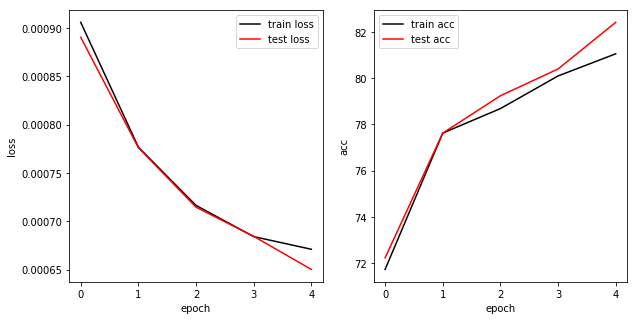

In [12]:
fig=plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_stats[:,0],'-k',label='train loss')
plt.plot(test_stats[:,0],'-r',label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.plot(train_stats[:,1],'-k',label='train acc')
plt.plot(test_stats[:,1],'-r',label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()


plt.show()

# Exercises

Experiment with this problem changing:

- size of hidden layer
- adding another hidden layer
- store accuracy and loss on training and test set

Go to the documentation and see how to save/load models